# EDA analysis

load packages and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter, OrderedDict
import re
import nltk
import string
from wordcloud import WordCloud

df = pd.read_csv('TrumpTweet.csv')
df2 = df[df['is_retweet']==False][['created_at','text']]

In [2]:
df2.head()

,created_at,text
0,11-07-2020 21:54:48,71000000 Legal Votes. The most EVER for a sitt...
1,11-07-2020 21:53:34,THE OBSERVERS WERE NOT ALLOWED INTO THE COUNTI...
2,11-07-2020 15:36:36,I WON THIS ELECTION BY A LOT!
3,11-07-2020 15:23:00,Georgia Counties Using Same Software as Michig...
4,11-07-2020 15:00:27,Lawyer’s Press Conference at Four Season’s Lan...


## Analyzing Tweet Stat

In [28]:
# add plot annotation
def addValueLabel(ax):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        label = y_value
        space = 5
        va = 'bottom'
        ax.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(0, space),          # Vertically shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                ha='center',                # Horizontally center label
                va=va) 
    return ax

### Tweet frequency

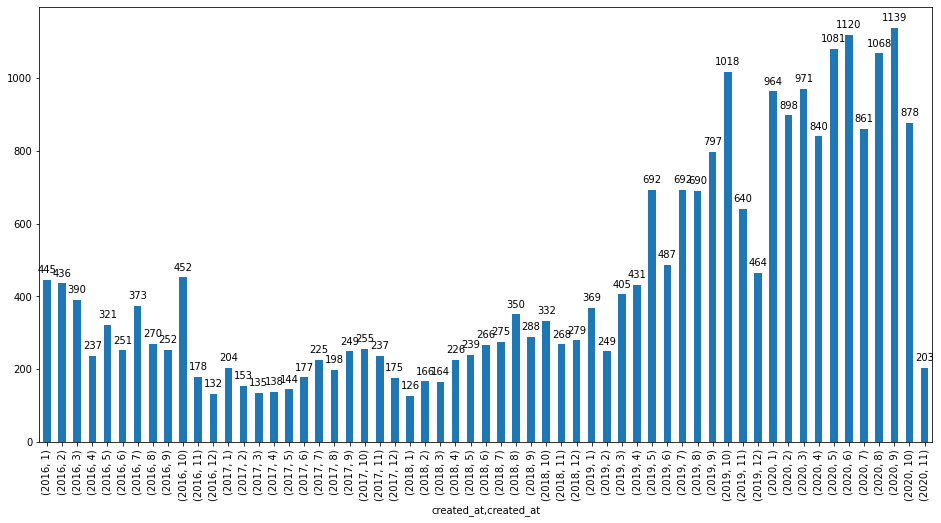

In [30]:
plt.rcParams["figure.figsize"] = (16,8)
df2.index = pd.to_datetime(df2['created_at'])
df_freq = df2.groupby(by=[df2.index.year,df2.index.month]).count()['text']
ax = df_freq.plot(kind='bar')
ax = addValueLabel(ax)
plt.show()

### Sentence length

<AxesSubplot:>

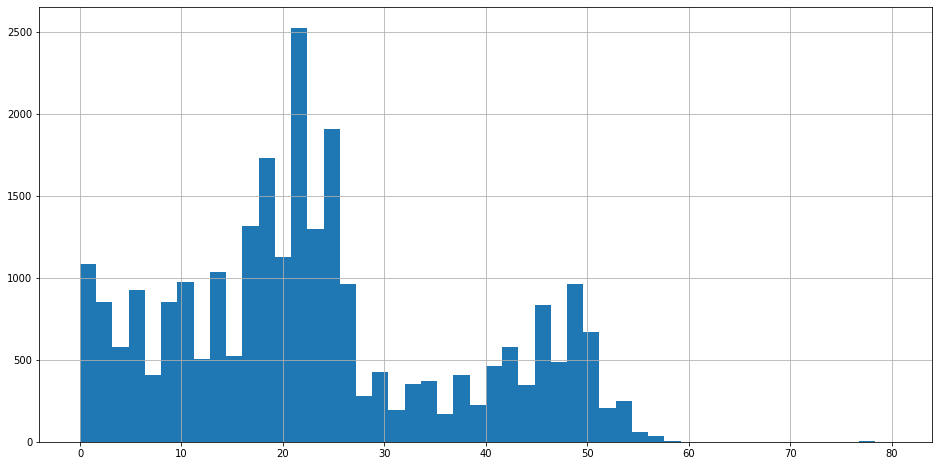

In [31]:
df2['text'].str.split().map(lambda x: len(x)).hist(bins=50,range=(0,80))

## Clean data

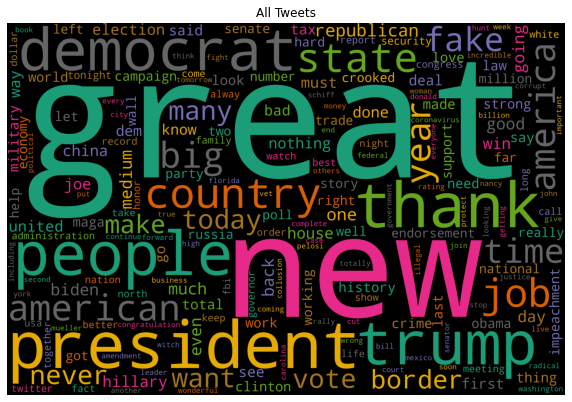

In [40]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords += ['amp','rt','u']
wn = nltk.WordNetLemmatizer()

def tweet_cleaner(text):
    # remove mention
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    # remove website
    text = re.sub(r'https?://[A-Za-z0-9./]+', '',text)
    # remove non-ASCII
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return ' '.join(text)

def plot_cloud(wordcloud, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud) 
    plt.title(title)
    plt.axis("off");

df2['text_clean'] = df2['text'].apply(lambda x: tweet_cleaner(x))
all_text = ' ' .join(list(df2['text_clean'].values))
wordcloud = WordCloud(width = 3000, 
                      height = 2000, 
                      random_state=1, 
                      colormap="Dark2",
                      collocations=False).generate(all_text)

plot_cloud(wordcloud,'All Tweets')

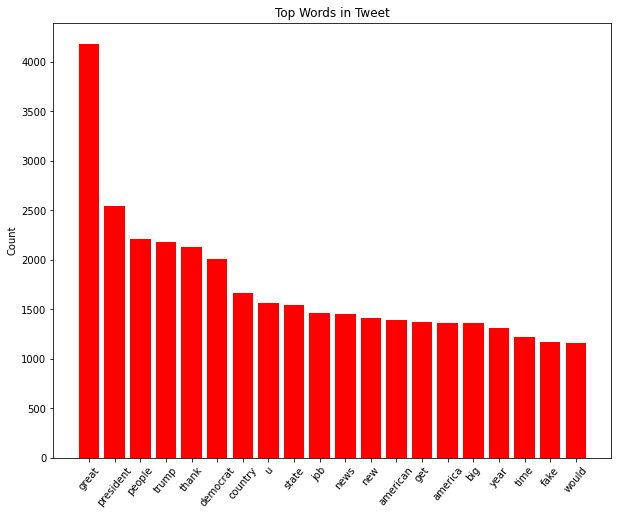

In [33]:
counter = Counter(all_text.split())
text_dict = [sorted(counter.items(), key=lambda kv: kv[1], reverse=True)]
x = []
y = []
for i in range(20):
    x.append(text_dict[0][i][0])
    y.append(text_dict[0][i][1])
plt.figure(figsize=[10,8])
plt.bar(x, y, color='red')
plt.ylabel("Count")
plt.title("Top Words in Tweet")
plt.xticks(rotation=50)
plt.show()

## Ngram exploration

In [34]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    cv = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = cv.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq
corpus = df2['text_clean'].values

### Bigram

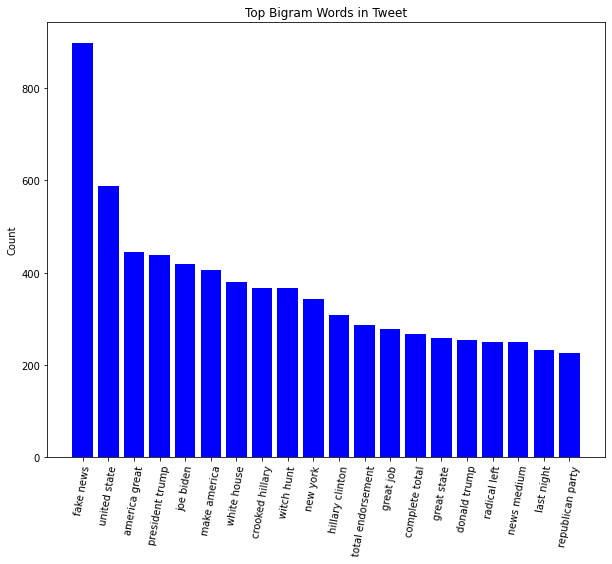

In [35]:
words_freq = get_top_ngram(corpus, 2)
x = []
y = []
for i in range(20):
    x.append(words_freq[i][0])
    y.append(words_freq[i][1])
plt.figure(figsize=[10,8])
plt.bar(x, y, color='blue')
plt.ylabel("Count")
plt.title("Top Bigram Words in Tweet")
plt.xticks(rotation=80)
plt.show()

### Trigram

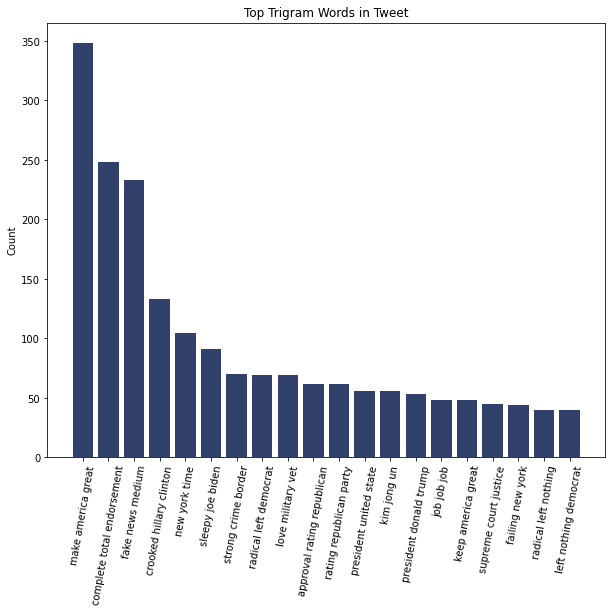

In [36]:
words_freq = get_top_ngram(corpus, 3)
x = []
y = []
for i in range(20):
    x.append(words_freq[i][0])
    y.append(words_freq[i][1])
plt.figure(figsize=[10,8])
plt.bar(x, y, color='#31416c')
plt.ylabel("Count")
plt.title("Top Trigram Words in Tweet")
plt.xticks(rotation=80)
plt.show()

## Text Complexity
The Flesch Kincaid readability score:

| Score | Note |
| --- | --- | 
| 90-100 | Very easy to read. Easily understood by an average 11-year-old student. |
| 80-90 | Easy to read. Conversational English for consumers. |
| 70-80 | Fairly easy to read. |
| 60-70 | Plain English. Easily understood by 13- to 15-year-old students. |
| 50-60 | Fairly difficult to read. |
| 30-50 | Difficult to read. |
| 10-30 | Very difficult to read. Best understood by university graduates. |
| 0-10 | Extremely difficult to read. Best understood by university graduates. |

In [37]:
from textstat import flesch_kincaid_grade

reading_ease_result = df2['text'].apply(lambda x : flesch_kincaid_grade(x))

<AxesSubplot:>

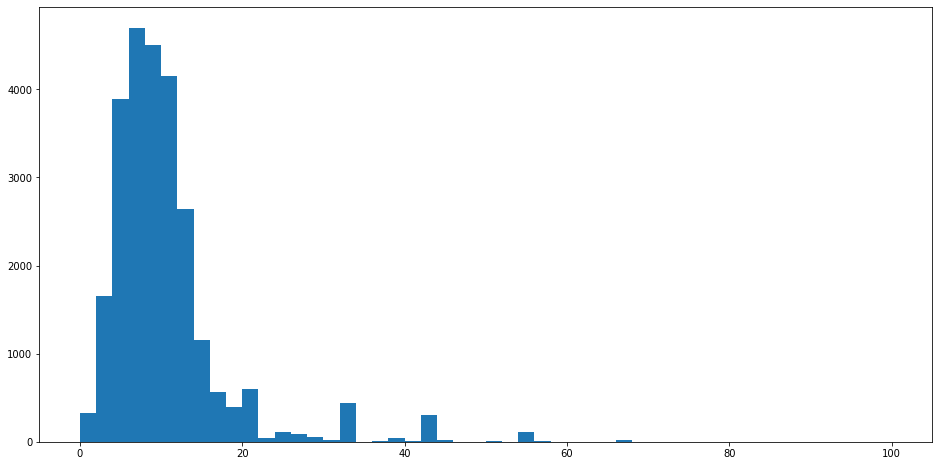

In [38]:
reading_ease_result.hist(bins=50,range=(0,100),grid=False)